# Curate dataset (unfiltered_dataset.csv)
This file shows the process of filtering to get the final submitted dataset. It shows the decisions taken and filters used. 

### Imports

In [8]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

Get the raw dataset

In [9]:
df = pd.read_csv("unfiltered_dataset_final.csv")
df['G_spec_int'] = df['G_spec_int']*1.234 # Spectral irradiance up to 4000 nm

C:\Users\syaba\AppData\Local\Temp\ipykernel_22192\1073098840.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("unfiltered_dataset_final.csv")


In [37]:
elec_cols = ['Vmpp', 'Impp', 'Pmpp', 'Voc', 'Isc', 'FF', 'Rsh', 'Rs', 'R2_Voc', 'NRMSE_Isc', 'V_ini', 'I_ini']
df_ambient = df.drop(columns=['filename', 'module_name', 'timestamp'] + elec_cols)
df_elec = df[elec_cols]

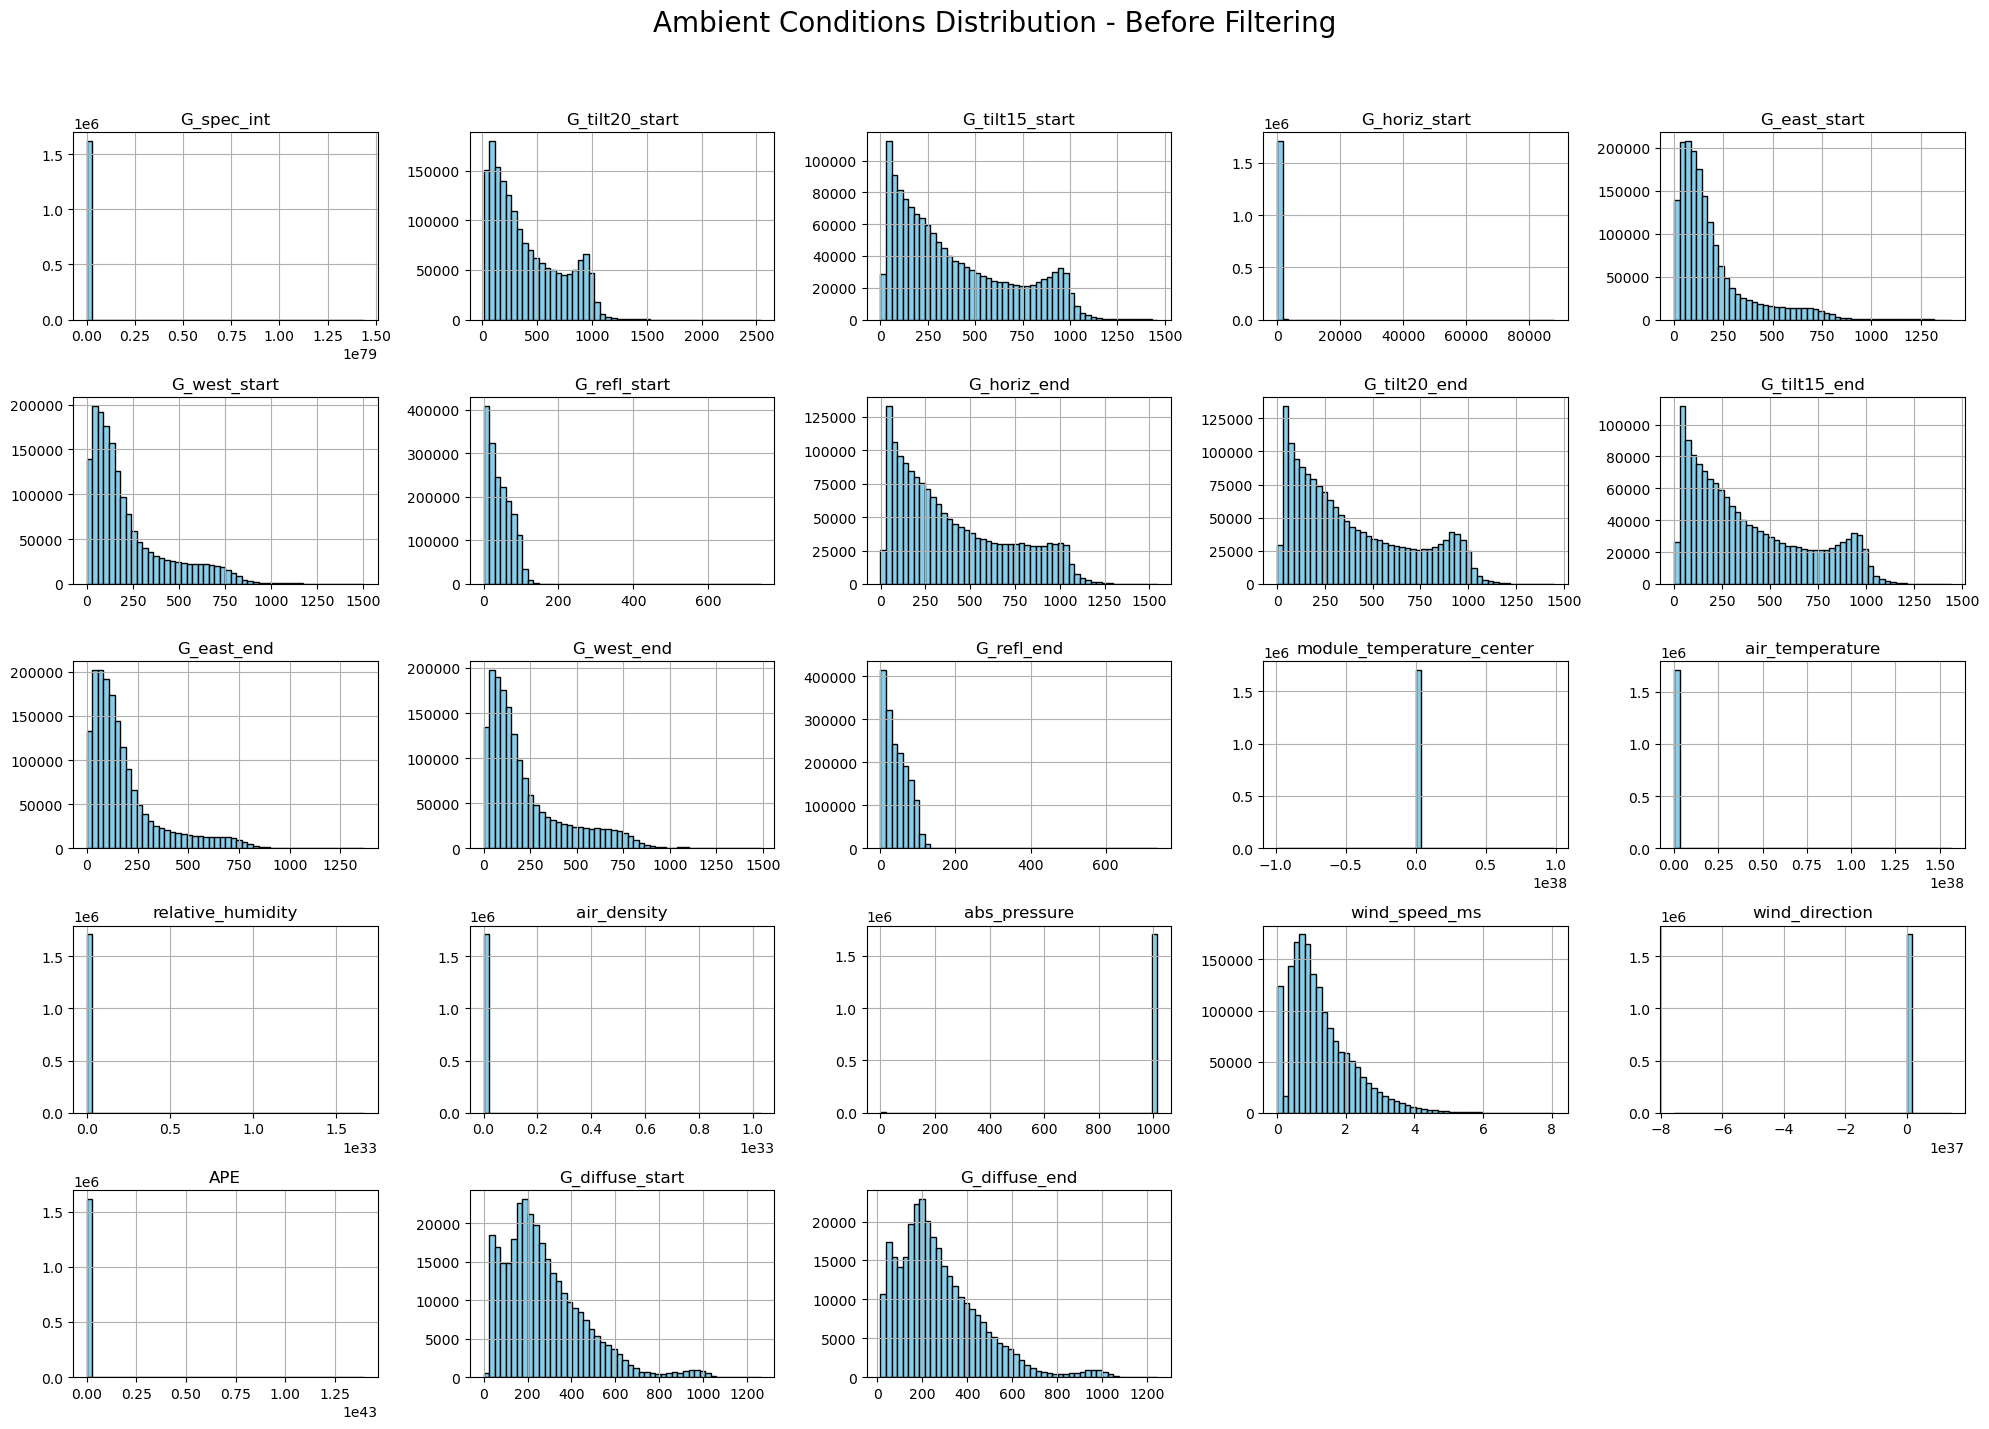

In [42]:
df_ambient.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle("Ambient Conditions Distribution - Before Filtering", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

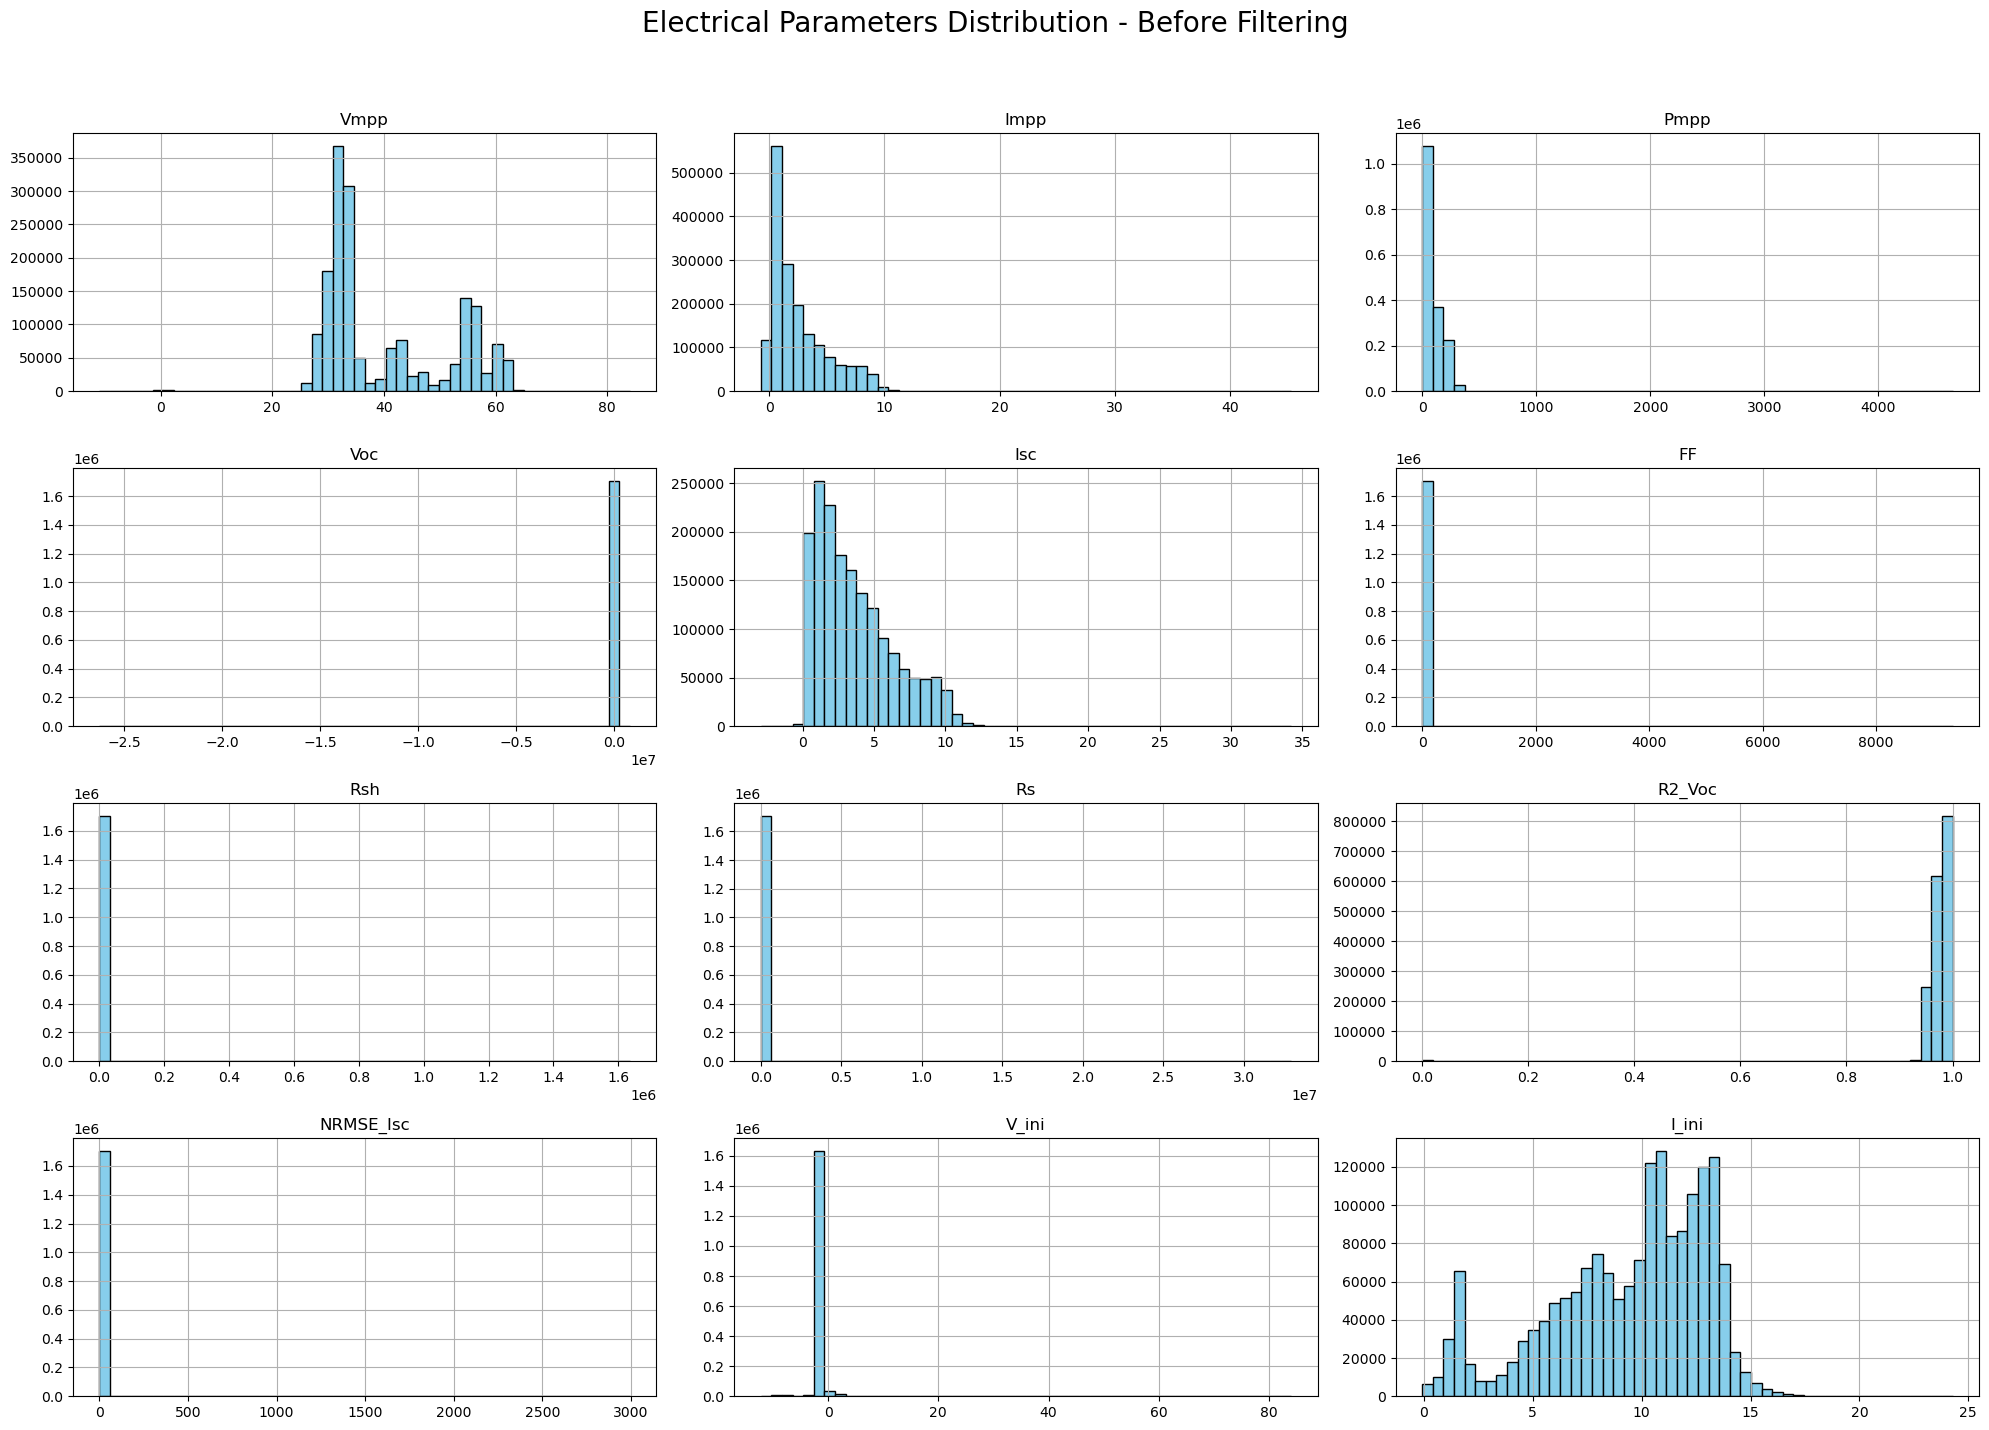

In [43]:
df_elec.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle("Electrical Parameters Distribution - Before Filtering", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Data Curating

Drop duplicates

In [10]:
initial_len = df.shape[0]
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
final_len = df.shape[0]
print(f"Original rows: {initial_len}.\nUnique rows: {final_len}.\nDropped {initial_len - final_len} samples.")


Original rows: 1749024.
Unique rows: 1708501.
Dropped 40523 samples.


Timestamp as datetime object

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by='timestamp', inplace=True)

In [12]:
df.columns

Index(['filename', 'module_name', 'timestamp', 'Vmpp', 'Impp', 'Pmpp',
       'G_spec_int', 'G_tilt20_start', 'G_tilt15_start', 'G_horiz_start',
       'G_east_start', 'G_west_start', 'G_refl_start', 'G_horiz_end',
       'G_tilt20_end', 'G_tilt15_end', 'G_east_end', 'G_west_end',
       'G_refl_end', 'module_temperature_center', 'module_temperature_lateral',
       'air_temperature', 'relative_humidity', 'air_density', 'abs_pressure',
       'wind_speed_ms', 'wind_direction', 'Voc', 'R2_Voc', 'Rs', 'FF', 'V_ini',
       'I_ini', 'APE', 'G_diffuse_start', 'G_diffuse_end', 'Isc', 'NRMSE_Isc',
       'Rsh'],
      dtype='object')

## Physics-based filtering
This stage of filtering is based on physical constraints. These are given by the measurement instrument's limits or by physical limits.

In [13]:
def clean_by_physics(df):
    clean_df = df.copy()
    
    # ==========================================
    # 1. INITIALIZATION & TYPE CASTING
    # ==========================================
    numeric_columns = clean_df.columns.drop(['filename', 'module_name', 'timestamp'])
    clean_df[numeric_columns] = clean_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    # ==========================================
    # 2. AMBIENT & ENVIRONMENTAL LIMITS
    # ==========================================
    # Temperature constraints
    clean_df.loc[(clean_df['air_temperature'] < -50) | (clean_df['air_temperature'] > 60), 'air_temperature'] = np.nan
    for col in ['module_temperature_center', 'module_temperature_lateral']:
        clean_df.loc[(clean_df[col] < -50) | (clean_df[col] > 150), col] = np.nan

    # Irradiance constraints
    g_cols = [c for c in clean_df.columns if c.startswith('G_')]
    for col in g_cols:
        clean_df.loc[(clean_df[col] < 0) & (clean_df[col] >= -5), col] = 0 
        clean_df.loc[(clean_df[col] < -5) | (clean_df[col] > 4000), col] = np.nan

    # Atmospheric constraints
    clean_df.loc[(clean_df['relative_humidity'] < 0) | (clean_df['relative_humidity'] > 100), 'relative_humidity'] = np.nan
    clean_df.loc[(clean_df['wind_direction'] < 0) | (clean_df['wind_direction'] > 360), 'wind_direction'] = np.nan
    clean_df.loc[(clean_df['wind_speed_ms'] < 0) | (clean_df['wind_speed_ms'] > 75), 'wind_speed_ms'] = np.nan
    clean_df.loc[(clean_df['air_density'] < 0.5) | (clean_df['air_density'] > 2), 'air_density'] = np.nan
    clean_df.loc[(clean_df['abs_pressure'] < 300) | (clean_df['abs_pressure'] > 1200), 'abs_pressure'] = np.nan
    clean_df.loc[(clean_df['APE'] < 1) | (clean_df['APE'] > 2), 'APE'] = np.nan
        
    # ==========================================
    # 3. FUNDAMENTAL ELECTRICAL LIMITS & REGRESSION QUALITY
    # ==========================================
    # Non-negative constraints
    clean_df.loc[clean_df['Isc'] < 0, ['Isc', 'Rsh']] = np.nan # Negative Isc also affects Rsh calculation
    clean_df.loc[clean_df['Voc'] < 0, ['Voc', 'Rs']] = np.nan
    clean_df.loc[clean_df['Impp'] < 0, 'Impp'] = np.nan
    clean_df.loc[clean_df['Vmpp'] < 0, 'Vmpp'] = np.nan    

    # Series and Shunt resistances 
    clean_df.loc[(clean_df['Rsh'] <= 0) | (clean_df['Rsh'] > 500), 'Rsh'] = np.nan
    clean_df.loc[(clean_df['Rs'] < 0) | (clean_df['Rs'] > 100), 'Rs'] = np.nan

    # Regression quality
    clean_df.loc[clean_df['R2_Voc'] < 0, ['R2_Voc', 'Voc', 'Rs']] = np.nan 
    clean_df.loc[(clean_df['NRMSE_Isc'] < 0) | (clean_df['NRMSE_Isc'] > 3), ['NRMSE_Isc', 'Isc', 'Rsh']] = np.nan
    
    # ==========================================
    # 4. RELATIONAL ELECTRICAL LIMITS
    # ==========================================
    i_ceiling = clean_df[['Isc', 'I_ini']].max(axis=1)
    mask_impp_invalid = (clean_df['Impp'] > (i_ceiling * 1.05))
    clean_df.loc[mask_impp_invalid & i_ceiling.notna(), 'Impp'] = np.nan

    mask_vmpp_invalid = (clean_df['Vmpp'] > (clean_df['Voc'] * 1.05))
    clean_df.loc[mask_vmpp_invalid & clean_df['Voc'].notna(), 'Vmpp'] = np.nan

    # ==========================================
    # 5. DATASHEET STC LIMITS (RELATIVE CHECKS)
    # ==========================================
    datasheet_values = pd.read_csv("../datasets/modules_metadata.csv") 
    clean_df = clean_df.merge(datasheet_values[['module_name', 'Voc_stc', 'Isc_stc', 'Pmpp_stc']], on='module_name', how='left')

    voc_rel_diff = (clean_df['Voc'] - clean_df['Voc_stc']).abs() / clean_df['Voc_stc']
    isc_upper_diff = (clean_df['Isc'] - clean_df['Isc_stc']) / clean_df['Isc_stc']

    # Nullify if STC checks fail
    clean_df.loc[voc_rel_diff > 0.5, ['Voc', 'Vmpp']] = np.nan 
    clean_df.loc[isc_upper_diff > 0.5, ['Isc', 'Impp', 'Rsh']] = np.nan

    # ==========================================
    # 6. FINAL DERIVED CALCULATIONS 
    # ==========================================
    # Calculate Pmpp ONLY from validated Vmpp and Impp
    clean_df['Pmpp'] = clean_df['Vmpp'] * clean_df['Impp']
    
    # Apply Pmpp STC upper bound and non-negative check
    pmpp_upper_diff = (clean_df['Pmpp'] - clean_df['Pmpp_stc']) / clean_df['Pmpp_stc']
    clean_df.loc[(clean_df['Pmpp'] < 0) | (pmpp_upper_diff > 0.5), 'Pmpp'] = np.nan

    # Calculate FF 
    clean_df['FF'] = clean_df['Pmpp'] / (clean_df['Voc'] * clean_df['Isc'])
    clean_df.loc[(clean_df['FF'] <= 0) | (clean_df['FF'] >= 1.0), ['FF', 'Rsh', 'Rs']] = np.nan

    return clean_df.drop(columns=['Voc_stc', 'Isc_stc', 'Pmpp_stc'])


df_physics = clean_by_physics(df)

In [33]:
def summarize_cleaning(df_before, df_after):
    """Summarizes the impact of cleaning by comparing counts before and after."""
    # List before and after cleaning per column
    before_counts = df_before.count()
    after_counts = df_after.count()

    # 2. Create the summary DataFrame
    stats_df = pd.DataFrame({
        'Before': before_counts,
        'After': after_counts,
        'Removed': before_counts - after_counts
    })

    # 3. Add a percentage column 
    stats_df['% Removed'] = ((stats_df['Removed'] / stats_df['Before']) * 100).round(2)

    # Display the results
    print(stats_df[stats_df['Removed'] > 0].sort_values('Removed', ascending=False))
    print(f"Summary: {before_counts.sum() - after_counts.sum()} datapoints removed. {(before_counts.sum() - after_counts.sum())/before_counts.sum()*100:.2f}% of total data.")

In [34]:
summarize_cleaning(df, df_physics)

                             Before    After  Removed  % Removed
APE                         1616183  1401146   215037      13.31
module_temperature_lateral  1708501  1541150   167351       9.80
G_spec_int                  1616184  1500062   116122       7.18
Rs                          1708282  1653821    54461       3.19
Rsh                         1705413  1653040    52373       3.07
FF                          1708094  1664736    43358       2.54
Pmpp                        1708501  1668181    40320       2.36
Impp                        1708501  1671869    36632       2.14
Isc                         1705413  1672596    32817       1.92
module_temperature_center   1708501  1699537     8964       0.52
G_diffuse_start              315066   307805     7261       2.30
G_diffuse_end                315066   307838     7228       2.29
abs_pressure                1708501  1701842     6659       0.39
relative_humidity           1708501  1703442     5059       0.30
Vmpp                     

## Analyze data distribution
Distribution plots after first filter stage

In [ ]:
df_ambient = df_physics.drop(columns=['filename', 'module_name', 'timestamp'] + elec_cols)
df_elec = df_physics[elec_cols]

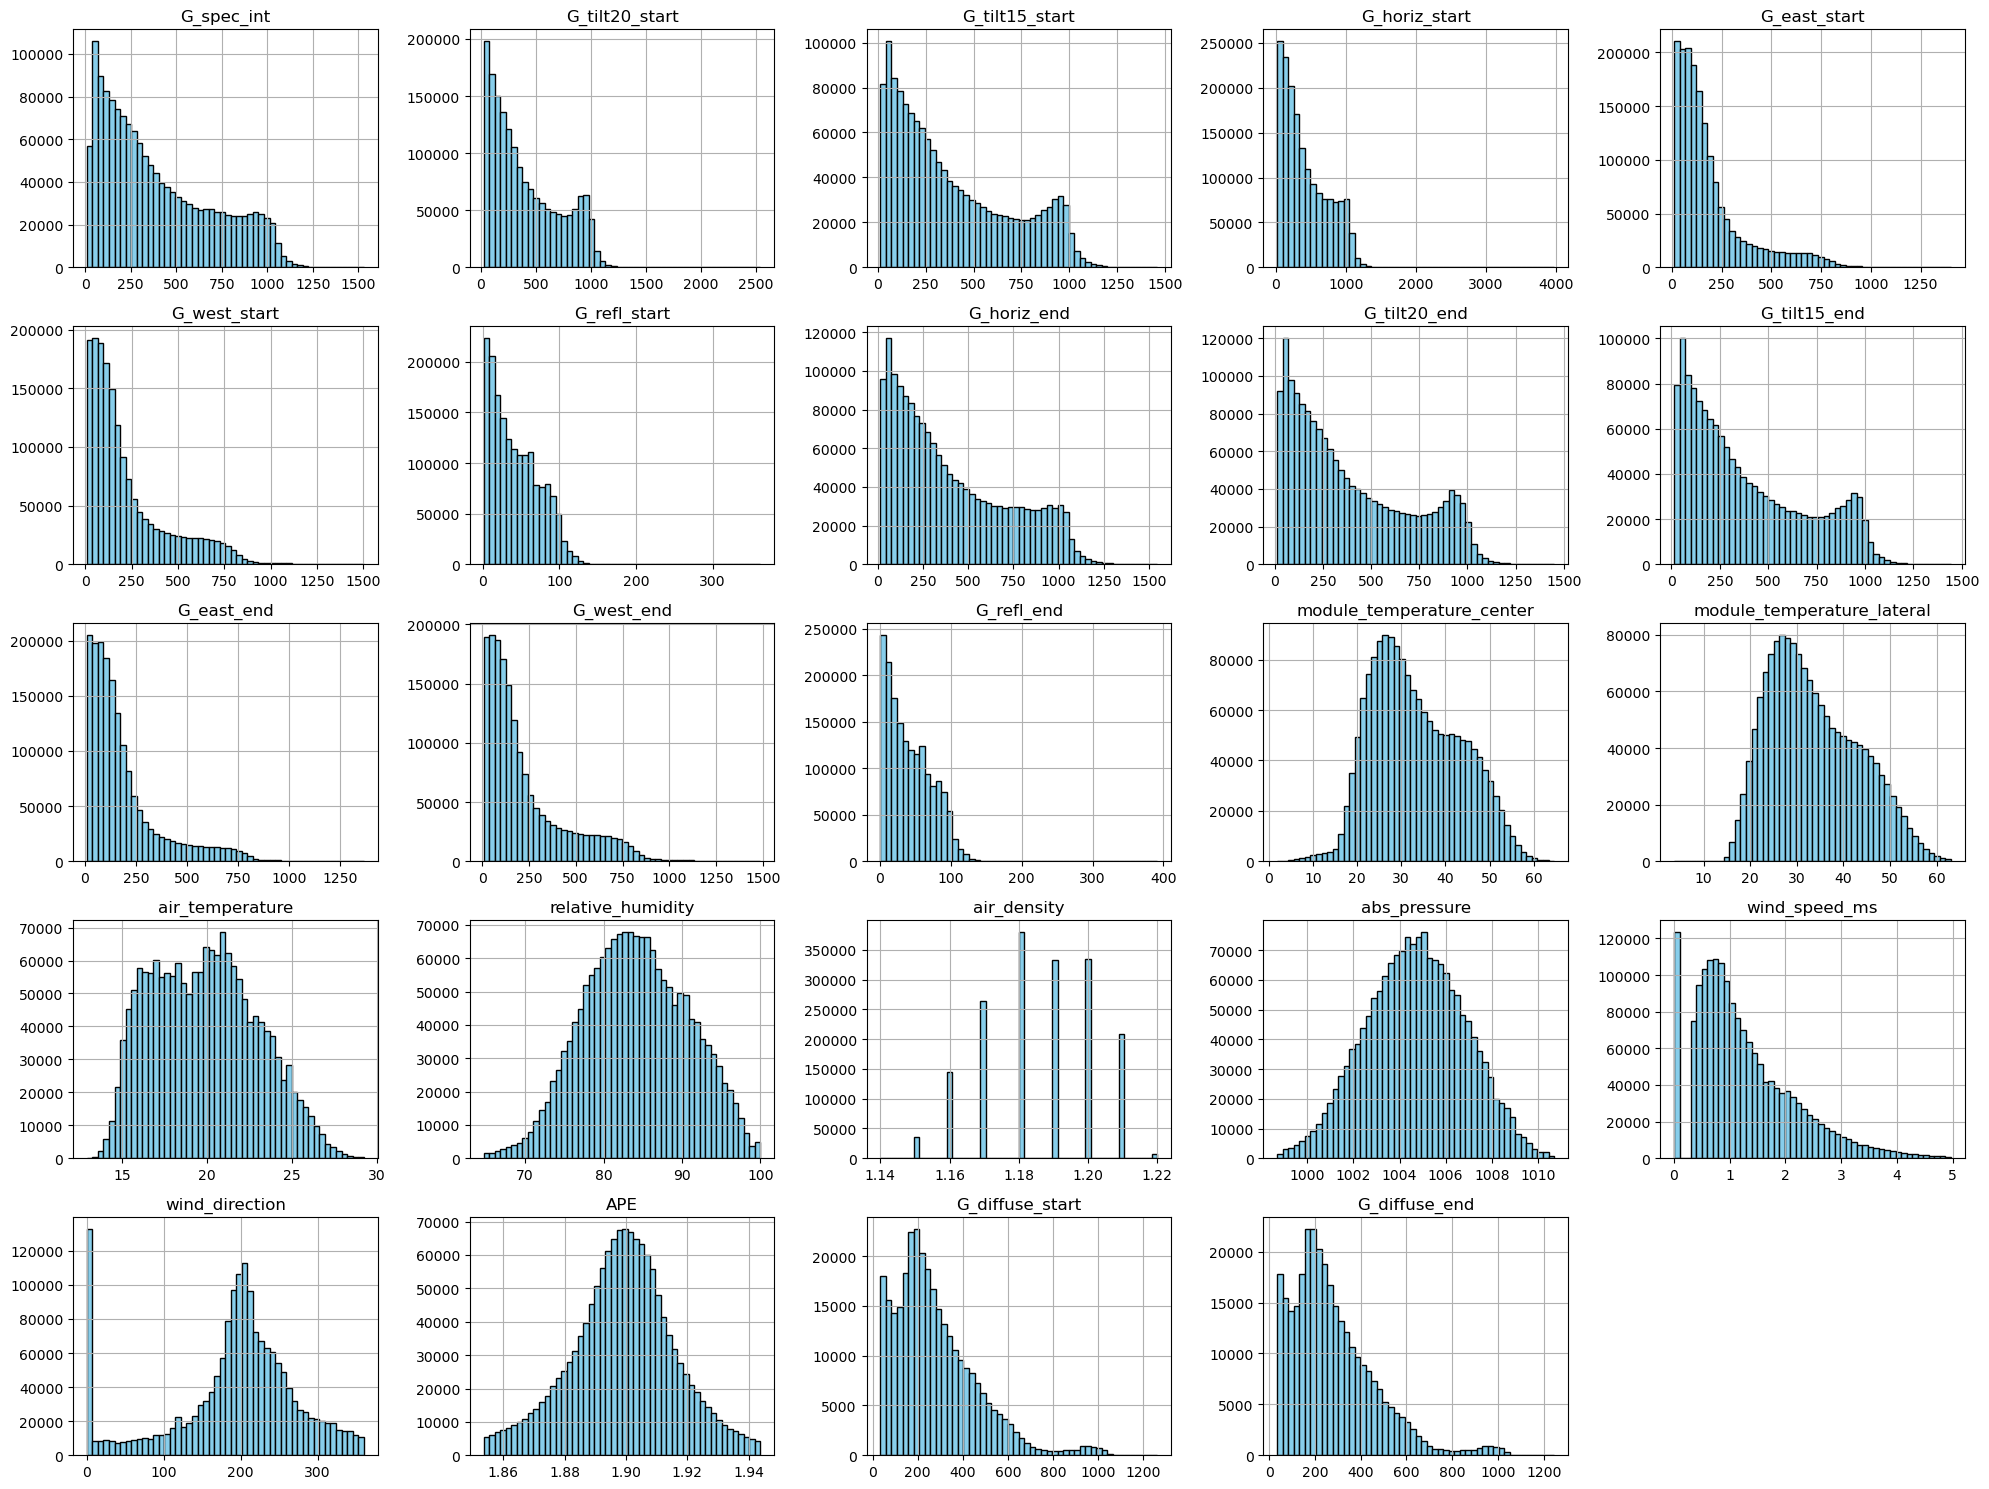

In [36]:
# Plot all numeric columns
df_ambient.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

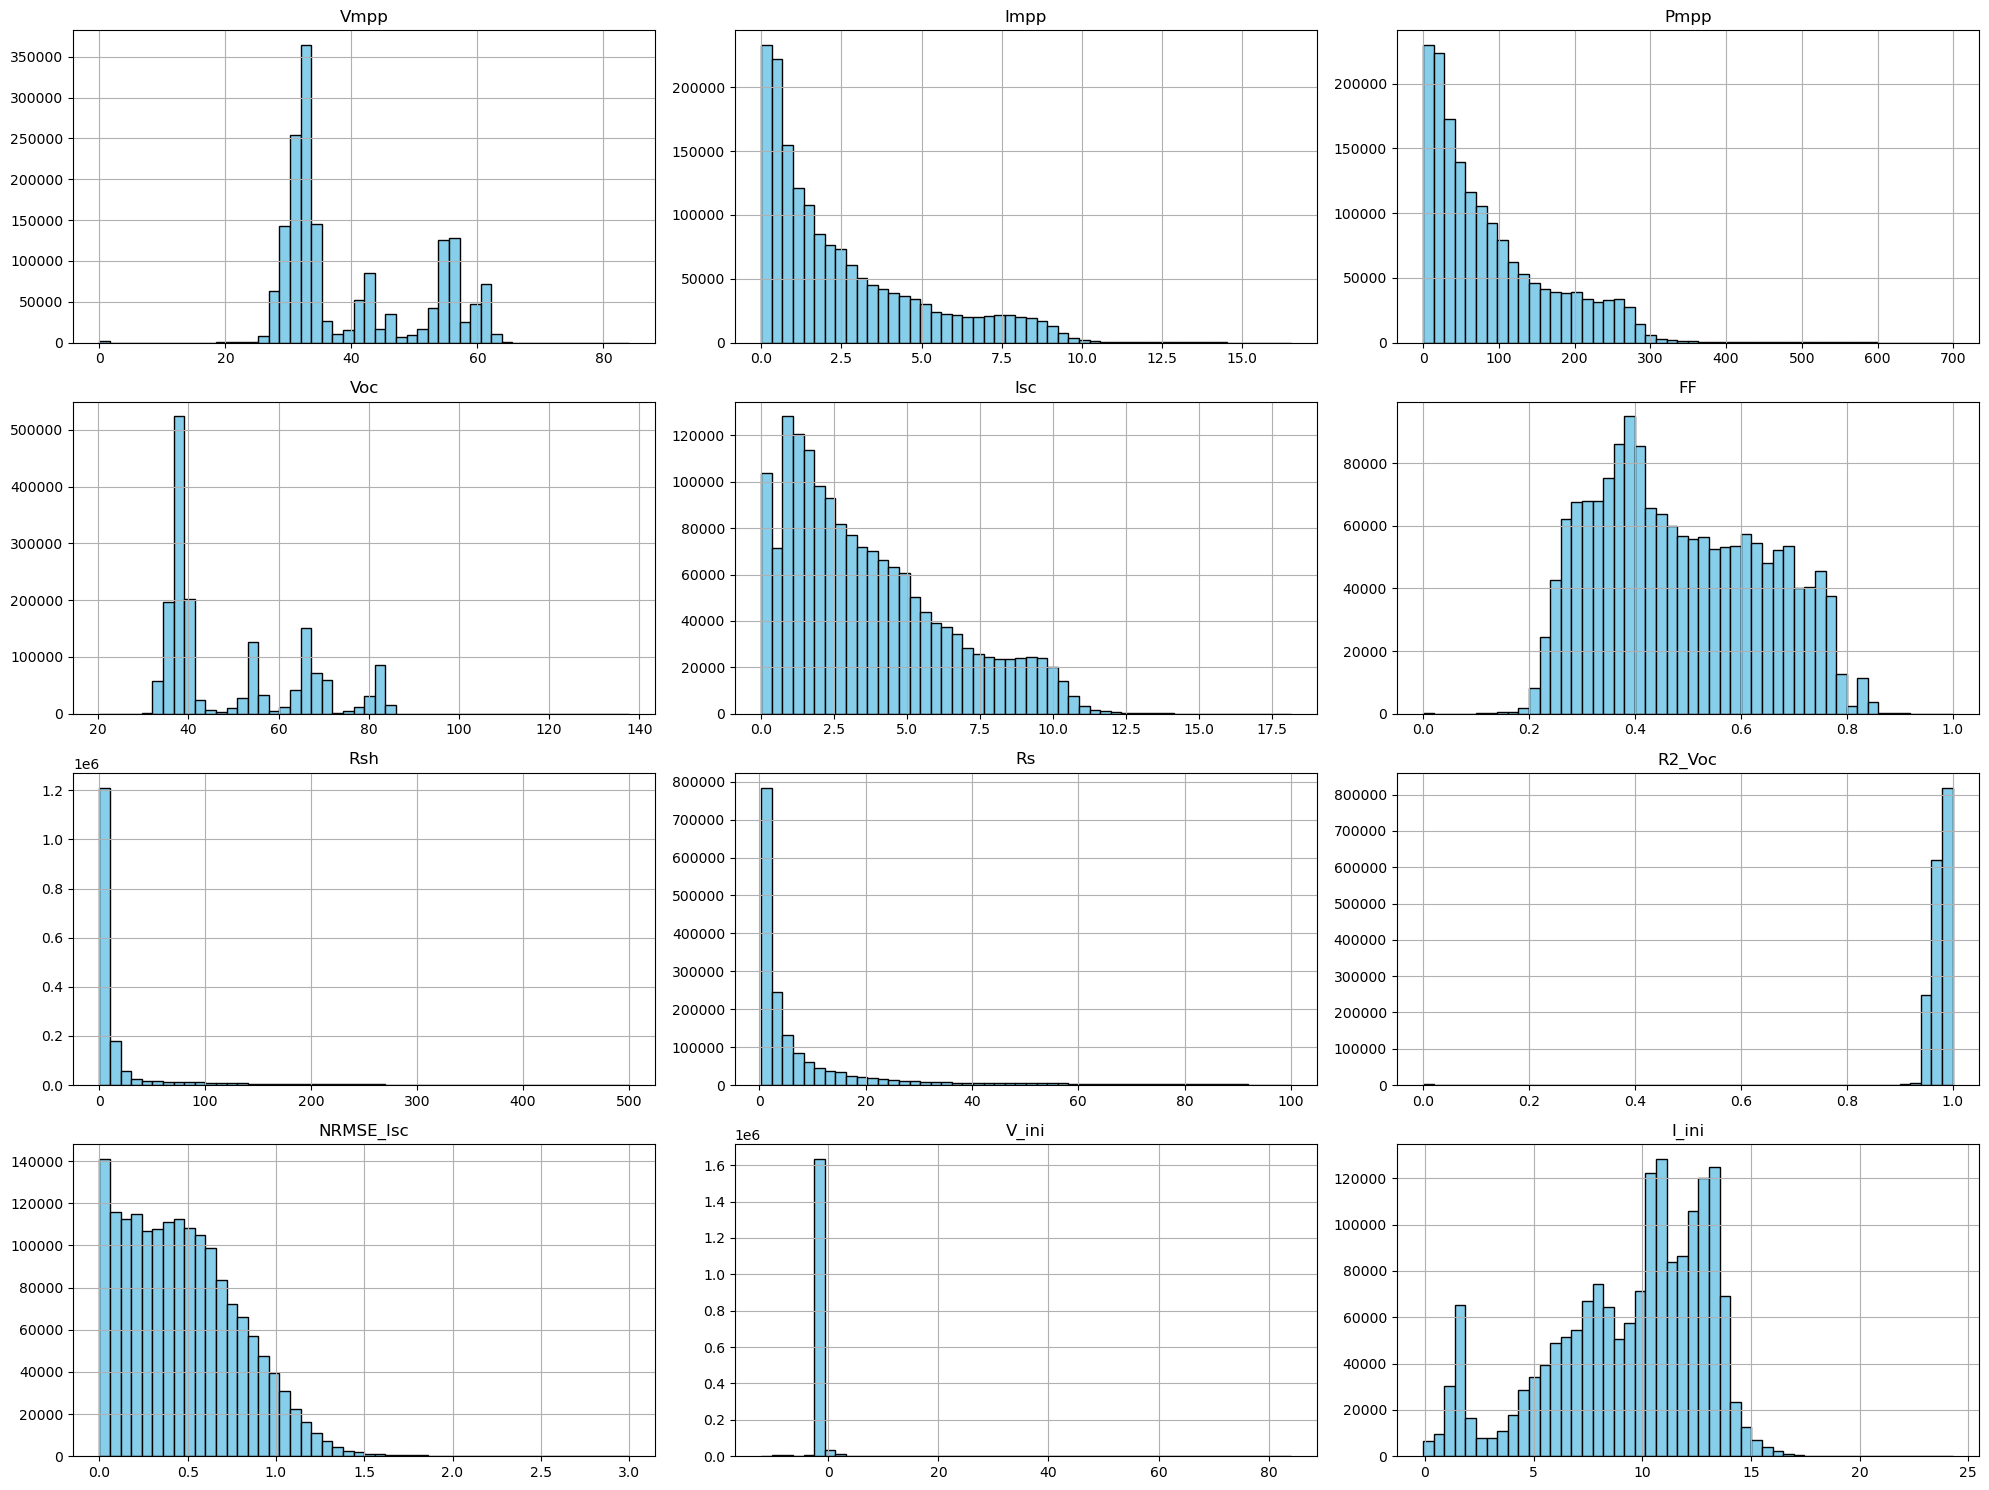

In [18]:
df_elec.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

## Statistics-based filtering
After the initial filters we still observe some outliers. The next statistics based filters deal with them

### Applying IQR filtering to normal-distributed variables
From a visual inspection of the histplots, we apply IQR filtering for the variables that follow normal distributions.

In [47]:
normal_looking = ['module_temperature_center', 'module_temperature_lateral',
       'air_temperature', 'relative_humidity', 'air_density', 'abs_pressure', 'FF', 'APE']

df_normal = df_physics[normal_looking]

In [48]:
def clean_by_iqr(df, multiplier=3.0):
    clean_df = df.copy()
    
    for col in clean_df.columns:
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Replace outliers with NaN
        clean_df.loc[(clean_df[col] < lower_bound) | (clean_df[col] > upper_bound), col] = np.nan
        
    return clean_df
    
df_normal_cleaned = clean_by_iqr(df_normal, multiplier=1.5) 

In [49]:
summarize_cleaning(df_normal, df_normal_cleaned)
df_physics[normal_looking] = df_normal_cleaned

                             Before    After  Removed  % Removed
APE                         1378962  1373058     5904       0.43
module_temperature_lateral  1540919  1540899       20       0.00
Summary: 5924 datapoints removed. 0.05% of total data.


## Transforming and applying IQR filter

Transforming irradiance and wind speed measurements to account for right skewdness before doing IQR filtering

In [50]:
def clean_skewed_outliers(df, multiplier=3.0):
    clean_df = df.copy()
    for col in clean_df.columns:
        # 1. Transform to log-space to normalize the "Right Skew"
        series_log = np.log1p(clean_df[col])
        
        # 2. Calculate IQR on the LOG-transformed data
        Q1 = series_log.quantile(0.25)
        Q3 = series_log.quantile(0.75)
        IQR = Q3 - Q1
        
        # 3. Define bounds in log-space
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        
        # 4. Create a mask of outliers
        # We do NOT drop them yet; we just identify their locations
        is_outlier = (series_log < lower) | (series_log > upper)
        
        # 5. Nullify the outliers in the ORIGINAL (untransformed) scale
        clean_df.loc[is_outlier, col] = np.nan
        
    return clean_df

# Now apply it
skewed_cols = [col for col in df_physics.columns if col.startswith('G_')] + ['wind_speed_ms']
df_skewed_cleaned = clean_skewed_outliers(df_physics[skewed_cols], multiplier=1.5)

In [51]:
summarize_cleaning(df_physics[skewed_cols], df_skewed_cleaned)
# Re-attach to original
df_physics[skewed_cols] = df_skewed_cleaned

                  Before    After  Removed  % Removed
G_diffuse_end     307838   304522     3316       1.08
G_diffuse_start   307805   304529     3276       1.06
wind_speed_ms    1704341  1703839      502       0.03
G_spec_int       1500062  1499722      340       0.02
G_east_end       1706646  1706562       84       0.00
G_east_start     1706726  1706651       75       0.00
G_west_start     1707716  1707710        6       0.00
G_refl_end       1708307  1708302        5       0.00
G_west_end       1707732  1707728        4       0.00
G_tilt15_end     1439044  1439042        2       0.00
G_horiz_end      1707988  1707987        1       0.00
G_tilt20_end     1708135  1708134        1       0.00
Summary: 7612 datapoints removed. 0.03% of total data.


As expected, the filtered out values reflect less than 1%, the physics filters got rid of most incorrect data

# Final Visualization

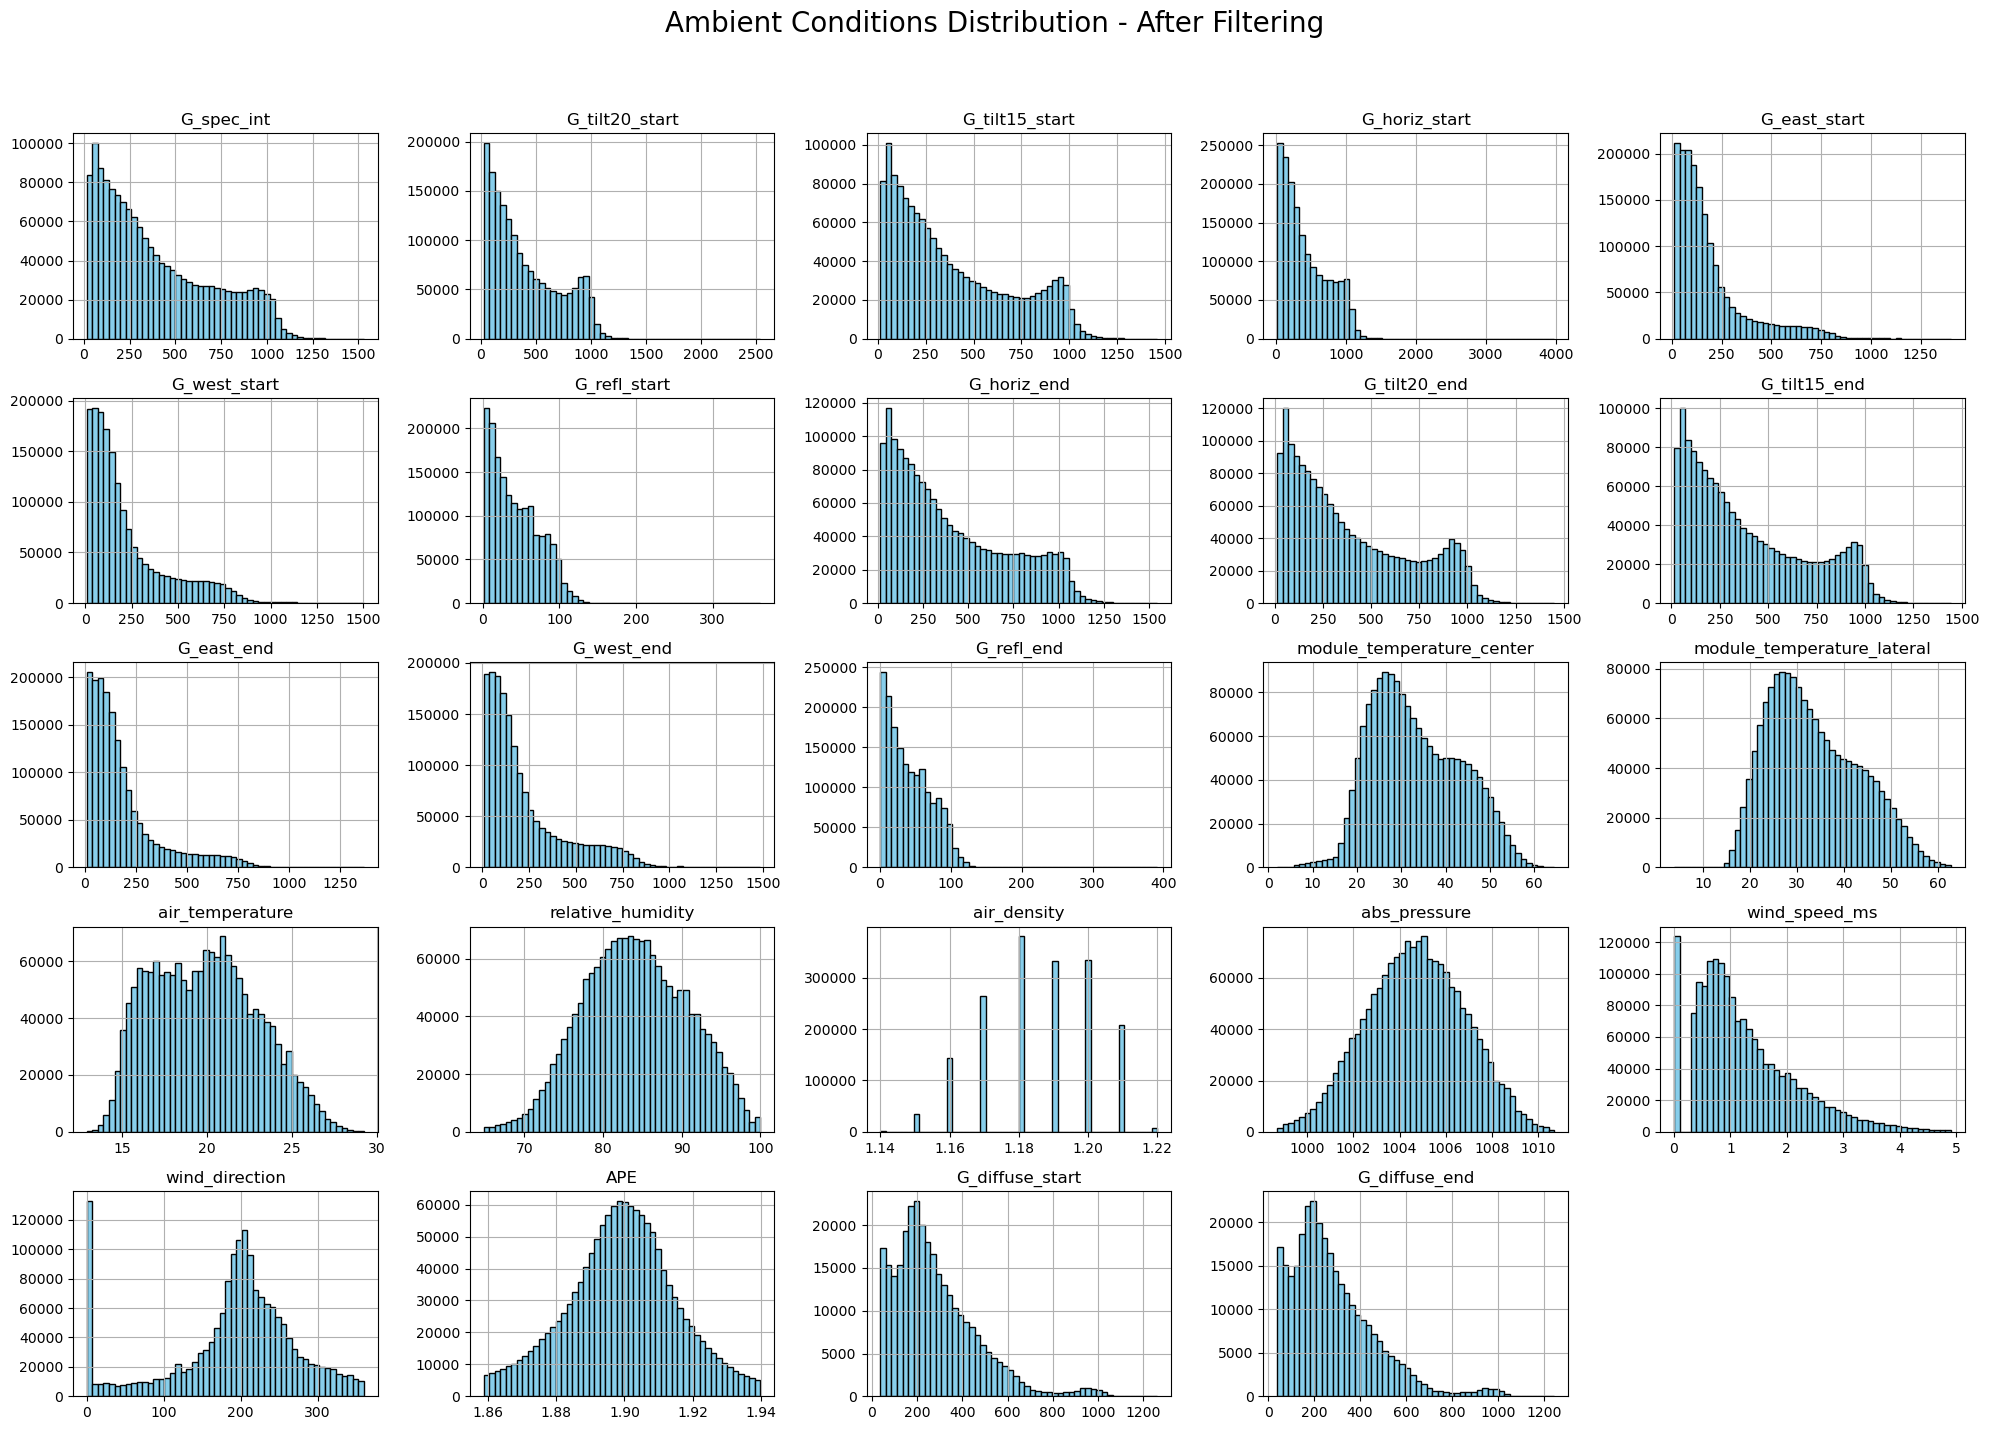

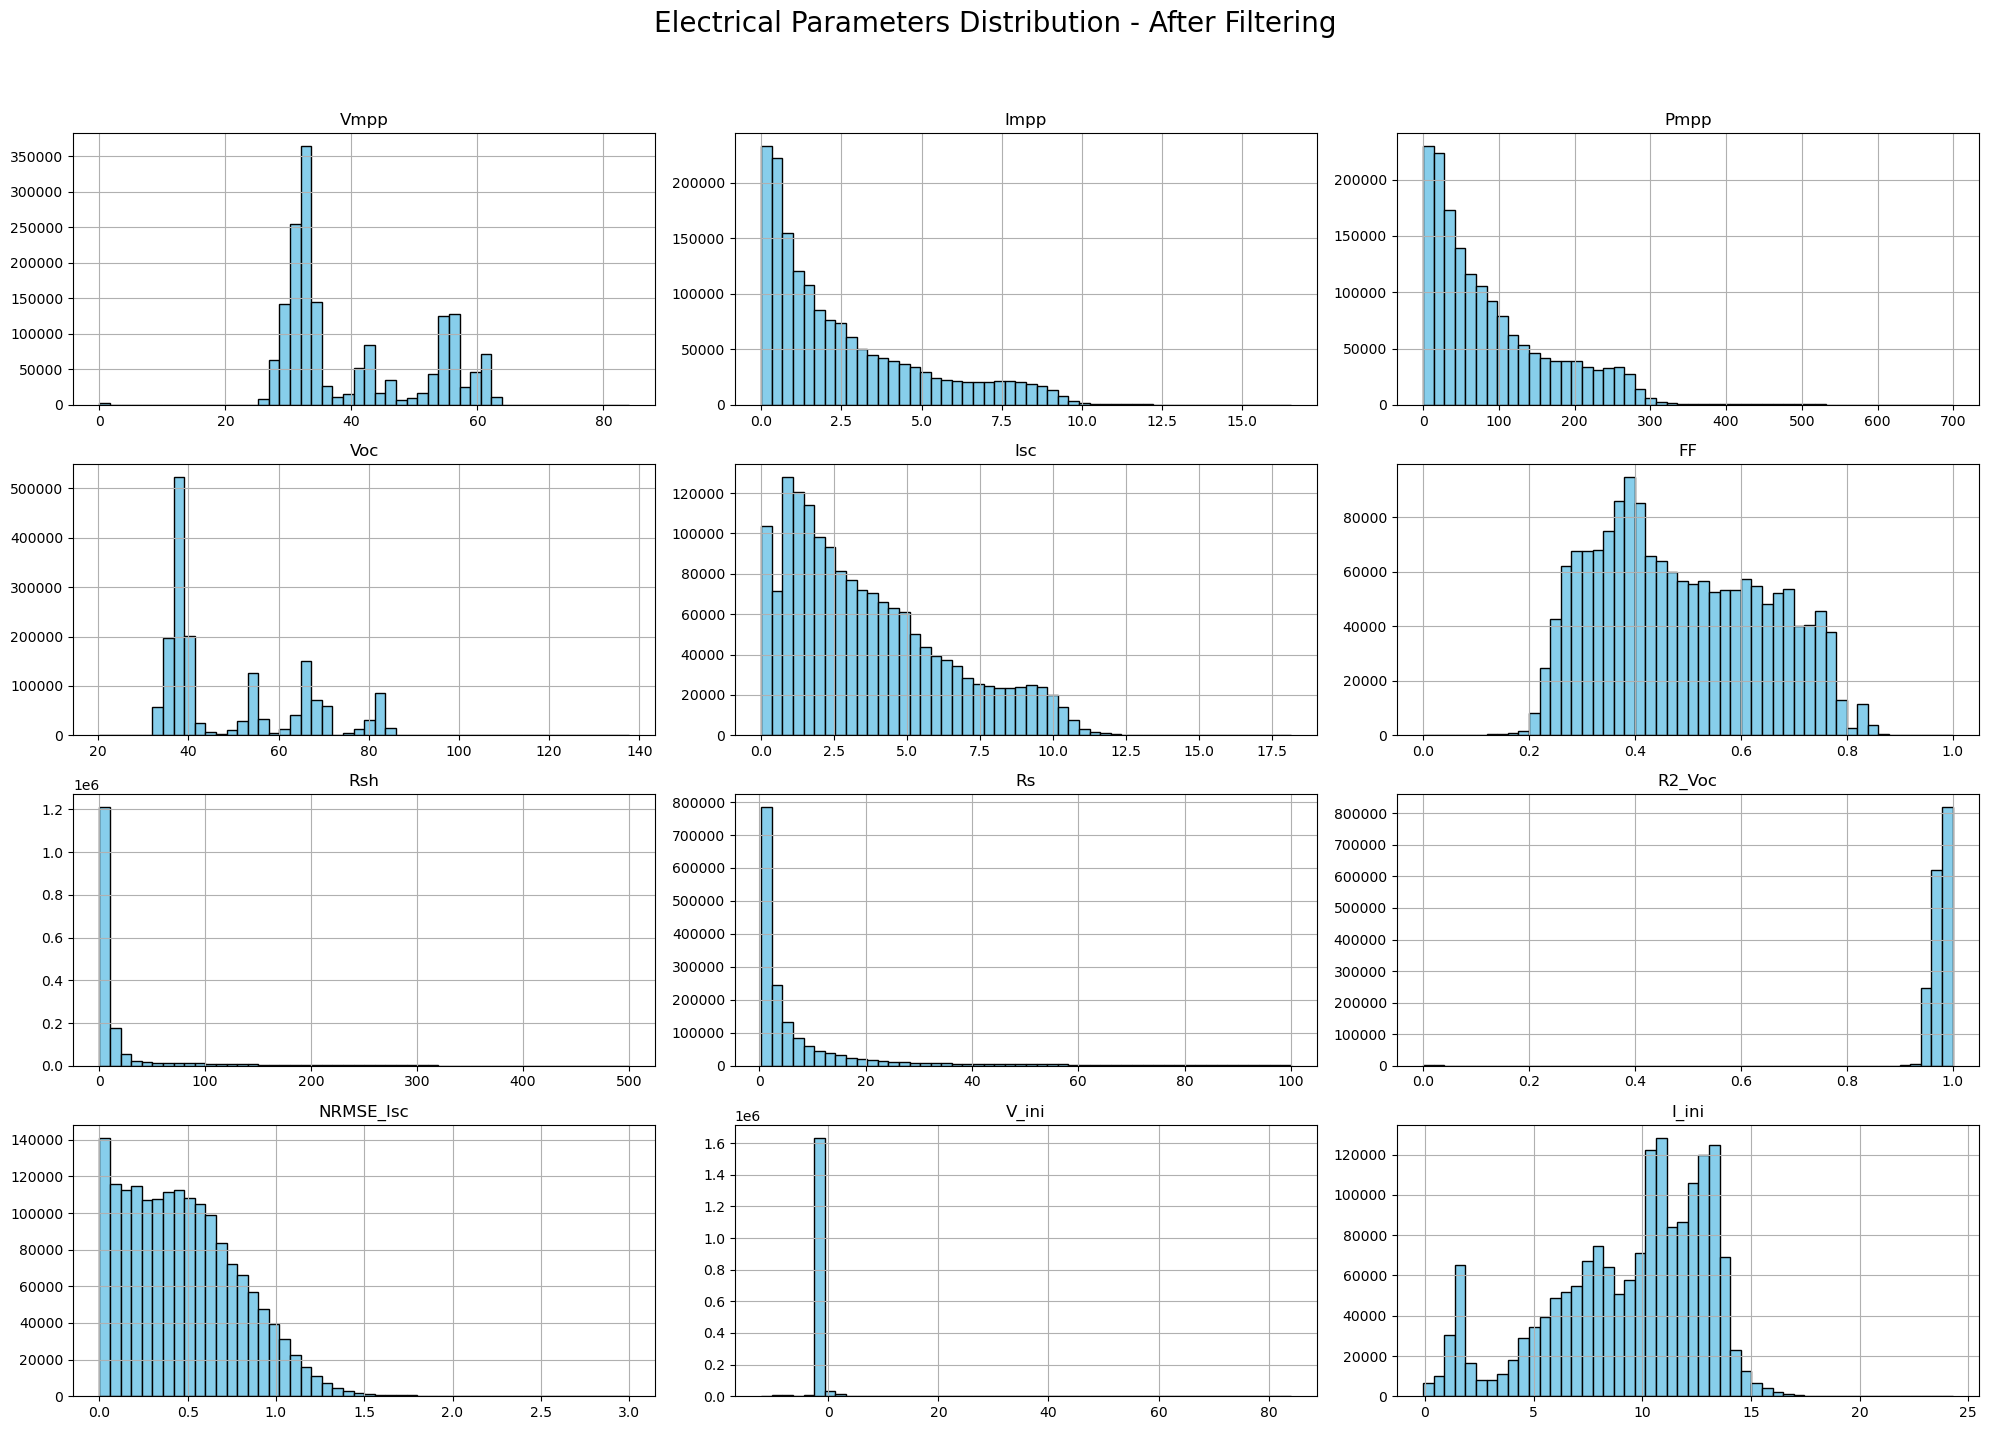

In [52]:
df_ambient = df_physics.drop(columns=['filename', 'module_name', 'timestamp'] + elec_cols)
df_elec = df_physics[elec_cols]
# Plot all numeric columns
df_ambient.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle("Ambient Conditions Distribution - After Filtering", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

df_elec.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle("Electrical Parameters Distribution - After Filtering", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final dataset 

In [27]:
summarize_cleaning(df, df_physics)

                             Before    After  Removed  % Removed
APE                         1616183  1401146   215037      13.31
module_temperature_lateral  1708501  1541150   167351       9.80
G_spec_int                  1616184  1500062   116122       7.18
Rs                          1708282  1653821    54461       3.19
Rsh                         1705413  1653040    52373       3.07
FF                          1708094  1664736    43358       2.54
Pmpp                        1708501  1668181    40320       2.36
Impp                        1708501  1671869    36632       2.14
Isc                         1705413  1672596    32817       1.92
module_temperature_center   1708501  1699537     8964       0.52
G_diffuse_start              315066   307805     7261       2.30
G_diffuse_end                315066   307838     7228       2.29
abs_pressure                1708501  1701842     6659       0.39
relative_humidity           1708501  1703442     5059       0.30
Vmpp                     

# Prepare for export

In [28]:
df_final = df_physics.reset_index(drop=True)

In [29]:
df_final.describe().T

,count,mean,min,25%,50%,75%,max,std
timestamp,1708501,2024-01-04 04:18:24.911891712,2022-01-01 06:30:01,2023-01-06 14:55:19,2024-01-09 11:38:06,2024-12-29 12:35:19,2025-12-31 15:05:01,NaN
Vmpp,1703822.0,40.132736,0.0,31.743656,33.708343,53.337977,84.053757,11.180087
Impp,1671869.0,2.546134,0.0,0.595388,1.639898,3.808011,16.518959,2.470019
Pmpp,1668181.0,89.769334,0.0,25.356734,63.884224,133.404565,699.031523,80.369537
G_spec_int,1500062.0,398.12953,8.851235,145.559164,313.869272,615.265368,1529.526324,299.17347
G_tilt20_start,1708500.0,401.502076,23.22,143.0575,312.13,630.28,2538.77,302.701271
G_tilt15_start,1439030.0,390.242248,13.15,134.66,301.09,611.49,1460.32,300.715799
G_horiz_start,1708319.0,421.361085,16.72,153.61,331.13,654.66,3978.53,316.03555
G_east_start,1706726.0,187.938165,9.95,67.28,128.72,229.5,1402.55,180.518042
G_west_start,1707716.0,228.454681,7.98,74.28,148.69,309.33,1502.25,214.837375


In [30]:
df_final.columns

Index(['filename', 'module_name', 'timestamp', 'Vmpp', 'Impp', 'Pmpp',
       'G_spec_int', 'G_tilt20_start', 'G_tilt15_start', 'G_horiz_start',
       'G_east_start', 'G_west_start', 'G_refl_start', 'G_horiz_end',
       'G_tilt20_end', 'G_tilt15_end', 'G_east_end', 'G_west_end',
       'G_refl_end', 'module_temperature_center', 'module_temperature_lateral',
       'air_temperature', 'relative_humidity', 'air_density', 'abs_pressure',
       'wind_speed_ms', 'wind_direction', 'Voc', 'R2_Voc', 'Rs', 'FF', 'V_ini',
       'I_ini', 'APE', 'G_diffuse_start', 'G_diffuse_end', 'Isc', 'NRMSE_Isc',
       'Rsh'],
      dtype='object')

In [31]:
df_final.drop('filename', axis=1, inplace=True)

In [32]:
# Define the logical column order
new_column_order = [
    # --- 1. ID & Metadata ---
    'module_name', 'timestamp',

    # --- 2. Electrical Parameters (IV Curve) ---
    'Vmpp', 'Impp', 'Pmpp',
    'Isc', 'Voc', 'FF',
    'Rsh', 'Rs',
    'NRMSE_Isc', 'R2_Voc',  # Quality/Fitting metrics
    'V_ini', 'I_ini',

    # --- 3. Spectral & Irradiance (The "Gs") ---
    'G_spec_int',        # Primary spectral integral
    'APE',               # Average Photon Energy (placed after G_spec_int as requested)
    
    # Grouping G sensors by type (Start/End pairs)
    'G_tilt20_start', 'G_tilt20_end',
    'G_tilt15_start', 'G_tilt15_end',
    'G_horiz_start',  'G_horiz_end',
    'G_diffuse_start','G_diffuse_end',
    'G_east_start',   'G_east_end',
    'G_west_start',   'G_west_end',
    'G_refl_start',   'G_refl_end',

    # --- 4. Module Temperature ---
    'module_temperature_center', 
    'module_temperature_lateral',

    # --- 5. Environmental / Weather ---
    'air_temperature', 
    'relative_humidity', 
    'air_density', 
    'abs_pressure', 
    'wind_speed_ms', 
    'wind_direction'
]

# Reorder the DataFrame
df_final = df_final[new_column_order]

# Save to CSV
df_final.to_csv("PV_dataset.csv", index=False)